In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
from dn_utils.behavioral_models import *
from scipy import stats
import scipy.io

plt.style.use('ggplot')
%matplotlib inline

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/sourcedata/behavioral" 
beh, meta = load_behavioral_data(root=beh_path)
n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


In [3]:
from scipy import stats

# Included subjects
sub_idx_filtered = np.delete(np.arange(32), meta['dim1'].index('m19'))

### Is performance above chance level? Do task differ in performance?

In [4]:
won_bool_mean = np.mean(beh[sub_idx_filtered, :, :, meta['dim4'].index('won_bool')], axis=2)
print(np.mean(won_bool_mean))
print(np.std(won_bool_mean))

# mean differ from chance
mean_chance = stats.ttest_1samp(np.mean(won_bool_mean, 1), popmean=0)
print(mean_chance)

# task difference
mean_difference = stats.ttest_rel(won_bool_mean[:, 0], won_bool_mean[:, 1])
print(mean_difference)

0.6252199413489736
0.05808228644807999
Ttest_1sampResult(statistic=79.16320556995025, pvalue=2.141607241437138e-36)
Ttest_relResult(statistic=0.4574407651379915, pvalue=0.6506499576279976)


### Do reward magnitudes affect choice?

In [5]:
magn_rl_diff = beh[sub_idx_filtered, :, :, meta['dim4'].index('magn_right')] \
             - beh[sub_idx_filtered, :, :, meta['dim4'].index('magn_left')] 
response = beh[sub_idx_filtered, :, :, meta['dim4'].index('response')]


diff_values = np.unique(magn_rl_diff)
response_probability = np.zeros((len(diff_values), 2))
response_probability[:, 0] = diff_values

for i, diff in enumerate(diff_values):
    diff_response = response[magn_rl_diff == diff]
    diff_response = diff_response[np.nonzero(diff_response)]
    response_probability[i, 1] = np.mean((diff_response + 1) / 2)
    
magn_choice_corr = stats.pearsonr(response_probability[:, 0], response_probability[:, 1])
print(magn_choice_corr)

(0.9407969676351546, 6.383845402240476e-20)


(0, 1)

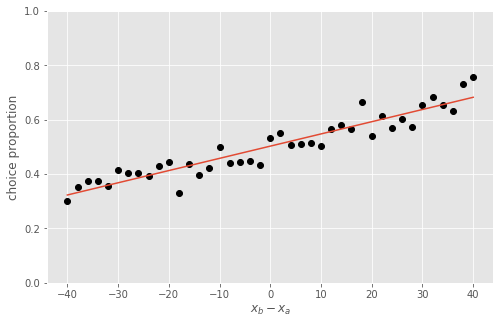

In [7]:
x = response_probability[:, 0]
y = response_probability[:, 1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), facecolor='w')
ax.plot(x, y, 'ko')
ax.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))

ax.set_xlabel('$x_b - x_a$')
ax.set_ylabel('choice proportion')
ax.set_ylim([0, 1])

### Is number of reversals related to esitimated parameters?

In [8]:
# Number of reversals for each participant
def calculate_reversals(response):
    """Calculate number of side switches in subject responses."""
    return len(np.nonzero(np.diff(response[np.nonzero(response)]))[0])

reversals = np.zeros((n_subjects, n_conditions))

for i in range(n_subjects):
    for j in range(n_conditions):
        reversals[i, j] = calculate_reversals(beh[i, j, :, 4])

In [9]:
alphas = np.load('matjags-dn/data/alpha_pdci_mle.npy')
mat = scipy.io.loadmat('matjags-dn/data/pmp_seq.mat', squeeze_me=True)

Text(0, 0.5, 'Mean number of reversals')

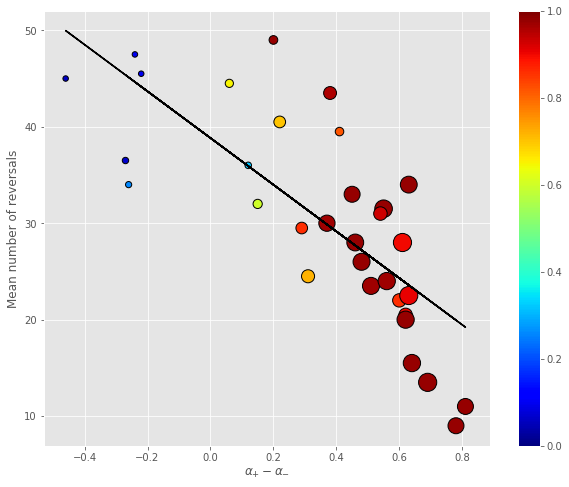

In [10]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w')

x = alphas[:,0]-alphas[:,1] # alpha+ (extreme) - alpha-
y = np.mean(reversals, axis=1)
s = 300*(mat['pmp_seq'][2, :] / np.max(mat['pmp_seq'][2, :])) + 30
c = alphas[:, 0]


sc = ax.scatter(
    x, y, s=s, c=c,
    cmap='jet', vmin=0, vmax=1,
    linewidth=1, edgecolor='k',
)
cb = plt.colorbar(sc)
ax.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), 'k')
ax.set_xlabel(r'$\alpha_{+} - \alpha_{-}$')
ax.set_ylabel('Mean number of reversals')


### What is the distribution of reaction time?

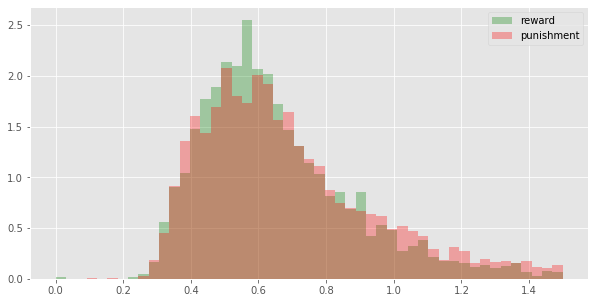

In [13]:
# Look at reaction time distribution for both conditions
fig, ax = plt.subplots(facecolor='w', figsize=(10, 5))

rt_rew = beh[:, 0, :, 5].flatten()
rt_pun = beh[:, 1, :, 5].flatten()

ax.hist(rt_rew, color='g', bins=np.linspace(0, 1.5, 50), alpha=.3, density=True, label='reward')
ax.hist(rt_pun, color='r', bins=np.linspace(0, 1.5, 50), alpha=.3, density=True, label='punishment');
ax.legend()